정상으로 MS구성하고 15개 고장 각각 구별할 수 있는 모델 생성

In [35]:
import cwru                      # Case Western Reserve University Bearing Data
import pandas as pd              # dataframe
import numpy as np               # array
from collections import Counter  # Class 갯수 세기
import matplotlib.pyplot as plt  # Visualization
%matplotlib inline
from scipy.fftpack import fft, ifft
from acoustics.cepstrum import complex_cepstrum, real_cepstrum
from sklearn.preprocessing import scale
from scipy.spatial import distance
from numpy.linalg import inv

In [297]:
cwru_data = cwru.CWRU("12DriveEndFault", "1750", 12000)

In [298]:
cwru_data.labels

('0.007-Ball',
 '0.007-InnerRace',
 '0.007-OuterRace12',
 '0.007-OuterRace3',
 '0.007-OuterRace6',
 '0.014-Ball',
 '0.014-InnerRace',
 '0.014-OuterRace6',
 '0.021-Ball',
 '0.021-InnerRace',
 '0.021-OuterRace12',
 '0.021-OuterRace3',
 '0.021-OuterRace6',
 '0.028-Ball',
 '0.028-InnerRace',
 'Normal')

In [299]:
x_train = np.asarray(cwru_data.X_train)
x_test = np.asarray(cwru_data.X_test)

y_train = np.asarray(cwru_data.y_train)
y_test = np.asarray(cwru_data.y_test)

In [300]:
y_test

array([ 5,  9,  5,  6, 13, 14,  3,  1,  0,  2, 15,  0,  7,  2,  6, 11, 10,
        2, 15,  0, 15,  9,  1, 15,  3, 14, 11,  5, 14,  1, 15,  7, 12,  8,
       13, 10,  9, 12, 11,  3,  8, 10,  4, 15, 15, 15, 15,  4, 12,  6,  8,
        4,  7, 13, 15])

In [301]:
print(Counter(y_train)) # Train 데이터 클래스 분포
print(Counter(y_test))  # Test 데이터 클래스 분포

Counter({15: 30, 0: 7, 1: 7, 2: 7, 3: 7, 4: 7, 5: 7, 6: 7, 7: 7, 8: 7, 9: 7, 10: 7, 11: 7, 12: 7, 13: 7, 14: 7})
Counter({15: 10, 0: 3, 1: 3, 2: 3, 3: 3, 4: 3, 5: 3, 6: 3, 7: 3, 8: 3, 9: 3, 10: 3, 11: 3, 12: 3, 13: 3, 14: 3})


In [302]:
# k class is abnormal
def make_dataset(k):
    exp_train_idx, = np.where((y_train == 15) | (y_train == k))
    exp_test_idx, = np.where((y_test == 15) | (y_test == k))
    
    x_train_here = x_train[exp_train_idx]
    y_train_here = y_train[exp_train_idx]
    x_test_here = x_test[exp_test_idx]
    y_test_here = y_test[exp_test_idx]

    normal_train_idx, = np.where(y_train_here == 15)
    normal_test_idx, = np.where(y_test_here == 15)

    abnormal_train_idx, = np.where(y_train_here == k)
    abnormal_test_idx, = np.where(y_test_here == k)
    
    return x_train_here, x_test_here, y_train_here, y_test_here, normal_train_idx, normal_test_idx, abnormal_train_idx, abnormal_test_idx
    

In [303]:
x_train, x_test, y_train, y_test, normal_train_idx, normal_test_idx, abnormal_train_idx, abnormal_test_idx = make_dataset(4)

In [304]:
for i in range(len(y_train)):
    if i in normal_train_idx:
        y_train[i] = 0 # Normal
    else:
        y_train[i] = 1 # Abnormal 

# Test 데이터 클래스 수정
for i in range(len(y_test)):
    if i in normal_test_idx:
        y_test[i] = 0
    else:
        y_test[i] = 1 
            

In [305]:
y_train.shape

(37,)

In [306]:
def do_FFT(signal_set):
    window = np.hamming(12000)
    fft_rlt = np.fft.fft(window * signal_set)
    return(fft_rlt)

def do_Cepstrum(spectrum):
    cep_result = (ifft(np.log(spectrum**2))**2).real
    return(cep_result)

    #ifft(np.log(np.abs(spectrum)))

In [307]:
#Data split
normal_x_train = pd.DataFrame(x_train[normal_train_idx])
normal_x_test = pd.DataFrame(x_test[normal_test_idx])

abnormal_x_train = pd.DataFrame(x_train[abnormal_train_idx])
abnormal_x_test = pd.DataFrame(x_test[abnormal_test_idx])

In [308]:
abnormal_x_train

,0,1,2,3,4,5,6,7,8,9,...,11990,11991,11992,11993,11994,11995,11996,11997,11998,11999
0,-0.261927,0.066598,-0.015025,0.059695,0.258678,-0.045076,-1.211360,0.785780,0.845069,-0.653801,...,-0.002437,-0.060507,-0.061725,-0.087309,-0.057664,-0.394717,0.473904,0.091370,-1.066793,-0.570553
1,0.430859,-0.432484,-0.124669,0.375225,0.329337,-0.539285,-0.165684,0.356951,0.027208,-0.325276,...,0.764257,1.161817,-1.679173,-0.362636,1.456231,0.382941,-1.284456,-0.336647,1.711254,-0.471874
2,-0.029644,0.119390,0.062538,-0.148628,0.141319,0.198171,0.109238,0.027614,-0.127105,-0.051979,...,-0.041421,0.279388,-0.179897,-0.156344,0.270048,0.024771,-0.539285,-0.021117,0.425986,-0.060507
3,-0.513295,0.105177,0.464158,-0.183146,-0.092588,0.518980,0.043045,-0.384971,0.229034,0.282231,...,0.727709,-0.534005,-0.189237,0.235531,-0.279388,0.060101,0.184770,0.017462,-0.436544,0.446697
4,-0.274921,0.374413,0.514919,-0.199795,-0.245683,0.334616,0.341114,-0.411367,-0.285480,0.435732,...,-1.008316,-0.134009,0.871464,0.073096,-0.490148,-0.091776,0.352890,-0.206293,-0.029238,0.134821
5,-0.249744,0.124669,0.432077,0.091776,-0.445884,0.102334,0.386596,-0.252993,-0.372383,0.183552,...,1.416434,0.103552,-1.345775,-0.002437,1.180497,0.121826,-0.996540,-0.039797,0.791465,0.002030
6,1.551662,0.891363,-1.869628,0.463346,1.816025,-0.174618,-1.874907,0.259490,1.344151,-0.951870,...,-0.015025,-0.089339,-0.081624,-0.188425,-0.171775,0.109238,0.006497,-0.124669,-0.019898,0.203450


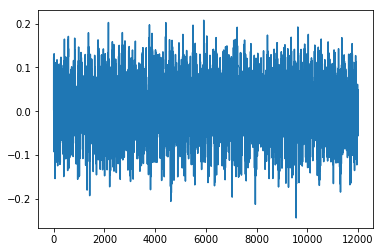

In [309]:
plt.plot(normal_x_train.iloc[0,:])

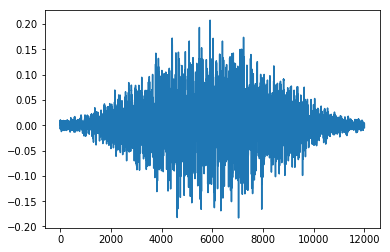

In [310]:
plt.plot(normal_x_train.iloc[0,:]*np.hamming(12000))

In [311]:
#Standardization
normal_x_train_scaled = pd.DataFrame(scale(normal_x_train, axis = 1))
normal_x_test_scaled = pd.DataFrame(scale(normal_x_test, axis = 1))

abnormal_x_train_scaled = pd.DataFrame(scale(abnormal_x_train, axis = 1))
abnormal_x_test_scaled = pd.DataFrame(scale(abnormal_x_test, axis = 1))

'''
#No-Standardization
normal_x_train_scaled = normal_x_train
normal_x_test_scaled = normal_x_test

abnormal_x_train_scaled = abnormal_x_train
abnormal_x_test_scaled = abnormal_x_test
'''

'\n#No-Standardization\nnormal_x_train_scaled = normal_x_train\nnormal_x_test_scaled = normal_x_test\n\nabnormal_x_train_scaled = abnormal_x_train\nabnormal_x_test_scaled = abnormal_x_test\n'

In [312]:
#Hamming and FFT
normal_x_train_fft = np.apply_along_axis(do_FFT, 1, normal_x_train_scaled)
normal_x_test_fft = np.apply_along_axis(do_FFT, 1, normal_x_test_scaled)

abnormal_x_train_fft = np.apply_along_axis(do_FFT, 1, abnormal_x_train_scaled)
abnormal_x_test_fft = np.apply_along_axis(do_FFT, 1, abnormal_x_test_scaled)

Text(0,0.5,'|Y(freq)|')

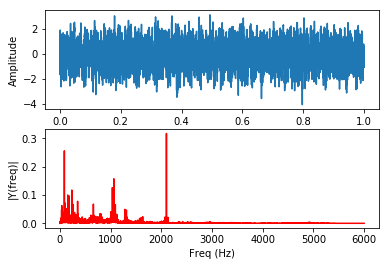

In [313]:
Fs = 12000.0;  # sampling rate
Ts = 1.0/Fs; # sampling interval
t = np.arange(0,1,Ts) # time vector

y = normal_x_train_scaled.iloc[0,:]

n = len(y) # length of the signal
k = np.arange(n)
T = n/Fs
frq = k/T # two sides frequency range
frq = frq[range(n/2)] # one side frequency range

Y = np.fft.fft(y)/n # fft computing and normalization
Y = Y[range(n/2)]

fig, ax = plt.subplots(2, 1)
ax[0].plot(t,y)
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Amplitude')
ax[1].plot(frq,abs(Y),'r') # plotting the spectrum
ax[1].set_xlabel('Freq (Hz)')
ax[1].set_ylabel('|Y(freq)|')


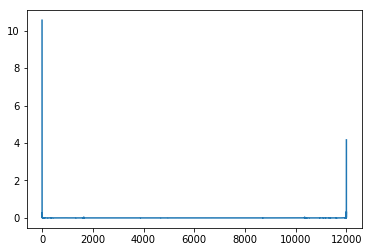

In [314]:
#Cepstrum
normal_x_train_cep = np.apply_along_axis(do_Cepstrum, 1, normal_x_train_fft)
normal_x_test_cep = np.apply_along_axis(do_Cepstrum, 1, normal_x_test_fft)

abnormal_x_train_cep = np.apply_along_axis(do_Cepstrum, 1, abnormal_x_train_fft)
abnormal_x_test_cep = np.apply_along_axis(do_Cepstrum, 1, abnormal_x_test_fft)

plt.plot(normal_x_train_cep[0])

In [315]:
#SI Functions
def get_mean(x):
    avg = np.mean(x)
    return(avg)

def get_std(x):
    std = np.std(x)
    return(std)

def get_skewness(x):
    skewness = sum((x - np.mean(x))**3) / ((len(x)-1)*(np.std(x)**3))
    return(skewness)

def get_kurtosis(x):
    kurtosis = sum((x - np.mean(x))**4) / ((len(x)-1)*(np.std(x)**4))
    return (kurtosis)

def get_p2p(x):
    p2p = (np.max(x) - np.min(x))
    return(p2p)

def get_rms(x):
    rms = np.sqrt(sum(x**2) / len(x))
    return(rms)

def get_crestFactor(x):
    crestFactor = get_p2p(x) / get_rms(x)
    return(crestFactor)

def get_shapeFactor(x):
    shapeFactor = get_rms(x) / get_mean(x)
    return(shapeFactor)
    
def get_marginFactor(x):
    marginFactor = np.max(x) / (np.mean((np.sqrt(abs(x))))**2)
    return(marginFactor)

def get_impulseFactor(x):
    impulseFactor = np.max(x) / np.mean(abs(x))
    return(impulseFactor)


In [316]:
def make_df(x):
    mean_value = np.apply_along_axis(get_mean, 1, x)
    std_value = np.apply_along_axis(get_std, 1, x)
    skewness_value = np.apply_along_axis(get_skewness, 1, x)
    kurtosis_value = np.apply_along_axis(get_kurtosis, 1, x)
    p2p_value = np.apply_along_axis(get_p2p, 1, x)
    rms_value = np.apply_along_axis(get_rms, 1, x)
    crestFactor_value = np.apply_along_axis(get_crestFactor, 1, x)
    shapeFactor_value = np.apply_along_axis(get_shapeFactor, 1, x)
    marginFactor_value = np.apply_along_axis(get_marginFactor, 1, x)
    impulseFactor_value = np.apply_along_axis(get_impulseFactor, 1, x)
    
    df = pd.DataFrame({'mean':mean_value, 'std':std_value, 'skewness':skewness_value, 'kurtosis':kurtosis_value, 'p2p':p2p_value, 'rms':rms_value,
                       'crest':crestFactor_value, 'shape':shapeFactor_value, 'margin':marginFactor_value, 'impulse':impulseFactor_value})
    
    return(df)

In [317]:
#make dataframe
normal_x_train_SI = make_df(normal_x_train_cep)
normal_x_test_SI = make_df(normal_x_test_cep)

abnormal_x_train_SI = make_df(abnormal_x_train_cep)
abnormal_x_test_SI = make_df(abnormal_x_test_cep)

In [318]:
#Standardization in MTS
def standardize(x,y):
    mean_mean = get_mean(x['mean'])
    std_mean = get_mean(x['std'])
    skewness_mean = get_mean(x['skewness'])
    kurtosis_mean = get_mean(x['kurtosis'])
    p2p_mean = get_mean(x['p2p'])
    rms_mean = get_mean(x['rms'])
    crest_mean = get_mean(x['crest'])
    shape_mean = get_mean(x['shape'])
    margin_mean = get_mean(x['margin'])
    impulse_mean = get_mean(x['impulse'])
    
    mean_std = get_std(x['mean'])
    std_std = get_std(x['std'])
    skewness_std = get_std(x['skewness'])
    kurtosis_std = get_std(x['kurtosis'])
    p2p_std = get_std(x['p2p'])
    rms_std = get_std(x['rms'])
    crest_std = get_std(x['crest'])
    shape_std = get_std(x['shape'])
    margin_std = get_std(x['margin'])
    impulse_std = get_std(x['impulse'])
    
    mean_value = (y['mean'] - mean_mean) / mean_std
    std_value = (y['std'] - std_mean) / std_std
    skewness_value = (y['skewness'] - skewness_mean) / skewness_std
    kurtosis_value = (y['kurtosis'] - kurtosis_mean) / kurtosis_std
    p2p_value = (y['p2p'] - p2p_mean) / p2p_std
    rms_value = (y['rms'] - rms_mean) / rms_std
    crest_value = (y['crest'] - crest_mean) / crest_std
    shape_value = (y['shape'] - shape_mean) / shape_std
    margin_value = (y['margin'] - margin_mean) / margin_std
    impulse_value = (y['impulse'] - impulse_mean) / impulse_std
    
    df = pd.DataFrame({'mean':mean_value, 'std':std_value, 'skewness':skewness_value, 'kurtosis':kurtosis_value, 'p2p':p2p_value, 'rms':rms_value,
                       'crest':crest_value, 'shape':shape_value, 'margin':margin_value, 'impulse':impulse_value})
    
    return(df)

In [319]:
normal_x_train_SI_scaled = standardize(normal_x_train_SI, normal_x_train_SI)
normal_x_test_SI_scaled = standardize(normal_x_train_SI, normal_x_test_SI)

abnormal_x_train_SI_scaled = standardize(normal_x_train_SI, abnormal_x_train_SI)
abnormal_x_test_SI_scaled = standardize(normal_x_train_SI, abnormal_x_test_SI)

In [320]:
def get_MD_distance(x):
    normal_cov_mat = pd.DataFrame(normal_x_train_SI_scaled).corr()
    dist = np.matmul(np.matmul(x, inv(normal_cov_mat)), np.transpose(x)) / len(x)
    return(dist)

In [321]:
normal_train_dist = np.apply_along_axis(get_MD_distance, 1, normal_x_train_SI_scaled)
normal_train_dist.sort()
normal_test_dist = np.apply_along_axis(get_MD_distance, 1, normal_x_test_SI_scaled)
normal_test_dist.sort()

abnormal_train_dist = np.apply_along_axis(get_MD_distance, 1, abnormal_x_train_SI_scaled)
abnormal_train_dist.sort()
abnormal_test_dist = np.apply_along_axis(get_MD_distance, 1, abnormal_x_test_SI_scaled)
abnormal_test_dist.sort()


In [322]:
print(normal_train_dist)
print('\n')
print(normal_test_dist)
print('\n')
print(abnormal_train_dist)
print('\n')
print(abnormal_test_dist)


[0.30119463 0.32178836 0.33481299 0.34227458 0.43175347 0.43226766
 0.45200172 0.48113691 0.48944318 0.56470721 0.5753051  0.60508689
 0.64763959 0.68175933 0.72592225 0.77553797 0.80917936 1.00222526
 1.05787534 1.21243245 1.26762055 1.29308915 1.52555421 1.70570715
 1.86046452 1.86603079 1.89640015 1.99370882 2.00543967 2.34926966]


[0.67727358 0.89394465 0.9004412  1.14581361 1.27581521 1.67557092
 2.37610312 2.7338898  3.28199883 4.68445915]


[114112.26873476 160807.76587699 227469.74547743 229205.21115023
 264746.18767562 499372.12217045 522808.52889907]


[285641.87186296 315616.91062571 319953.29366893]


In [323]:
#L_12(2^11) orthogonal array
ortho_array = np.matrix([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                       [1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2],
                       [1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2],
                       [1, 2, 1, 2, 2, 1, 2, 2, 1, 1, 2],
                       [1, 2, 2, 1, 2, 2, 1, 2, 1, 2, 1],
                       [1, 2, 2, 2, 1, 2, 2, 1, 2, 1, 1],
                       [2, 1, 2, 2, 1, 1, 2, 2, 1, 2, 1],
                       [2, 1, 2, 1, 2, 2, 2, 1, 1, 1, 2],
                       [2, 1, 1, 2, 2, 2, 1, 2, 2, 1, 1],
                       [2, 2, 2, 1, 1, 1, 1, 2, 2, 1, 2],
                       [2, 2, 1, 2, 1, 2, 1, 1, 1, 2, 2],
                       [2, 2, 1, 1, 2, 1, 2, 1, 2, 2, 1]])

In [324]:
otho_df = pd.DataFrame(ortho_array, columns=['mean', 'std', 'skewness', 'kurtosis', 'p2p', 'rms', 'crest', 'shape', 'margin', 'impulse','DUMMY'])

In [325]:
def get_exp_col(n):
    condition = otho_df.iloc[n,:]==1
    col = list(otho_df.loc[n,condition].index)
    if('DUMMY' in col):
        col.pop()
    return(col)

In [326]:
def get_MD_distance_exp(x,n):
    col = get_exp_col(n)
    normal_cov_mat = pd.DataFrame(normal_x_train_SI_scaled[col]).corr()
    dist = np.matmul(np.matmul(x, inv(normal_cov_mat)), np.transpose(x)) / len(x)
    return(dist)

In [327]:
def get_MD_exp(n,df):
    col = get_exp_col(n)
    target_df = df[col]
    dist = np.apply_along_axis(get_MD_distance_exp, 1, target_df, n)
    return(dist)

In [328]:
def get_MD_matrix(df):
    arr = np.empty([12, df.shape[0]])
    for i in range(0,12):
        arr[i,:] = get_MD_exp(i,df)
        
    return(arr)

In [329]:
normal_x_test_MD_matrix = get_MD_matrix(normal_x_test_SI_scaled)

abnormal_x_train_MD_matrix = get_MD_matrix(abnormal_x_train_SI_scaled)
abnormal_x_test_MD_matrix = get_MD_matrix(abnormal_x_test_SI_scaled)


In [330]:
def cal_larger_better_SNRatio(mat):
    SNRatio = []
    for i in range(0,mat.shape[0]):
        dist = mat[i]
        SN = -10 * np.log10(np.mean(1/(dist)))
        SNRatio.append(SN)
        
    return(SNRatio)

In [331]:
def cal_smaller_better_SNRatio(mat):
    SNRatio = []
    for i in range(0,mat.shape[0]):
        dist = mat[i]
        SN = -10 * np.log10(np.mean(dist))
        SNRatio.append(SN)
        
    return(SNRatio)

In [332]:
SNRatio_normal_test = cal_smaller_better_SNRatio(normal_x_test_MD_matrix)

SNRatio_abnormal_train = cal_larger_better_SNRatio(abnormal_x_train_MD_matrix)
SNRatio_abnormal_test = cal_larger_better_SNRatio(abnormal_x_test_MD_matrix)

In [333]:
def cal_smaller_better_gain(mat,col_name):
    idx_1 = list(otho_df.loc[otho_df[col_name] == 1].index)
    idx_2 = list(otho_df.loc[otho_df[col_name] == 2].index)
    
    SN = np.array(cal_smaller_better_SNRatio(mat))
    values_1 = np.mean(SN[idx_1])
    values_2 = np.mean(SN[idx_2])
    
    gain = values_1 - values_2
    
    return(gain)

In [334]:
def cal_larger_better_gain(mat,col_name):
    idx_1 = list(otho_df.loc[otho_df[col_name] == 1].index)
    idx_2 = list(otho_df.loc[otho_df[col_name] == 2].index)
    
    SN = np.array(cal_larger_better_SNRatio(mat))
    values_1 = np.mean(SN[idx_1])
    values_2 = np.mean(SN[idx_2])
    
    gain = values_1 - values_2
    
    return(gain)

In [335]:
#get gain
column_names=['mean', 'std', 'skewness', 'kurtosis', 'p2p', 'rms', 'crest', 'shape', 'margin', 'impulse']

def get_normal_test_gain(col):
    columns = col
    gain_values = []
    for i in range(0,len(columns)):
        gain_values.append(cal_smaller_better_gain(normal_x_test_MD_matrix, columns[i]))
        
    return(gain_values)
 
def get_abnormal_train_gain(col):
    columns = col
    gain_values = []
    for i in range(0,len(columns)):
        gain_values.append(cal_larger_better_gain(abnormal_x_train_MD_matrix, columns[i]))
        
    return(gain_values)

def get_abnormal_test_gain(col):
    columns = col
    gain_values = []
    for i in range(0,len(columns)):
        gain_values.append(cal_larger_better_gain(abnormal_x_test_MD_matrix, columns[i]))
        
    return(gain_values)

In [336]:
normal_test_gain = get_normal_test_gain(column_names)

abnormal_train_gain = get_abnormal_train_gain(column_names)
abnormal_test_gain = get_abnormal_test_gain(column_names)

In [337]:
print('Normal Test Gain')
print(pd.DataFrame(normal_test_gain, index=column_names))
print('\n')

print('abnormal_train_gain')
print(pd.DataFrame(abnormal_train_gain, index=column_names))
print('\n')

print('abnormal_test_gain')
print(pd.DataFrame(abnormal_test_gain, index=column_names))

Normal Test Gain
                 0
mean     -0.481293
std      -0.311759
skewness  0.079479
kurtosis -0.122072
p2p       0.008835
rms      -0.428197
crest    -1.009785
shape    -0.432587
margin   -0.308295
impulse  -0.383280


abnormal_train_gain
                 0
mean      1.704851
std       3.416720
skewness  5.699394
kurtosis  8.750298
p2p       0.218581
rms      -0.276214
crest     3.766276
shape    -0.399114
margin    5.163728
impulse   7.395757


abnormal_test_gain
                 0
mean      3.693837
std       6.104494
skewness  3.442882
kurtosis  7.053698
p2p       0.137564
rms       1.813322
crest     4.987908
shape     1.671218
margin    4.314257
impulse   6.352643


In [338]:
# Select variables that show positive SN ratio in Normal test
normal_train_taguchi = normal_x_train_SI_scaled[['skewness','p2p']]
normal_test_taguchi = normal_x_test_SI_scaled[['skewness','p2p']]

abnormal_train_taguchi = abnormal_x_train_SI_scaled[['skewness','p2p']]
abnormal_test_taguchi = abnormal_x_test_SI_scaled[['skewness','p2p']]


In [339]:
def get_MD_distance_taguchi(x):
    normal_cov_mat = pd.DataFrame(normal_train_taguchi).corr()
    dist = np.matmul(np.matmul(x, inv(normal_cov_mat)), np.transpose(x)) / len(x)
    return(dist)

In [340]:
normal_train_dist_taguchi = np.apply_along_axis(get_MD_distance_taguchi, 1, normal_train_taguchi)
normal_train_dist_taguchi.sort()
normal_test_dist_taguchi = np.apply_along_axis(get_MD_distance_taguchi, 1, normal_test_taguchi)
normal_test_dist_taguchi.sort()

abnormal_train_dist_taguchi = np.apply_along_axis(get_MD_distance_taguchi, 1, abnormal_train_taguchi)
abnormal_train_dist_taguchi.sort()
abnormal_test_dist_taguchi = np.apply_along_axis(get_MD_distance_taguchi, 1, abnormal_test_taguchi)
abnormal_test_dist_taguchi.sort()

In [341]:
# Results of Feature selection
print('Normal Train (Mahalanobis Space)')
print(normal_train_dist_taguchi)
print('\n')

print('Normal Test')
print(normal_test_dist_taguchi)
print('\n')

print('Abnormal Train')
print(abnormal_train_dist_taguchi)
print('\n')

print('Abnormal Test')
print(abnormal_test_dist_taguchi)

Normal Train (Mahalanobis Space)
[0.00654796 0.0077547  0.09886609 0.15662498 0.16138751 0.18032054
 0.20888895 0.24246398 0.25498061 0.36454925 0.38698137 0.46727654
 0.51902982 0.66334821 0.76580009 0.88756591 0.89438347 0.95481363
 1.03236315 1.07188036 1.18986179 1.29536843 1.47258861 1.5869728
 1.8014643  2.17569495 2.50584956 2.50915109 2.93127543 3.20594593]


Normal Test
[0.05585211 0.09788478 0.37706222 0.90840727 0.91148417 0.9534677
 1.09079742 1.37706905 2.12772026 2.60184539]


Abnormal Train
[346.33067156 352.93339763 369.2171615  445.26034946 512.1409241
 537.05591209 550.26690775]


Abnormal Test
[314.43673425 342.80375347 352.28292705]
